In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 339 (delta 100), reused 77 (delta 60), pack-reused 163
Receiving objects: 100% (339/339), 55.19 MiB | 20.69 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=25374 sha256=0a0adc7e93d5441a7efafcd7418f025ff8b106b41c8c4e2368ed637c8a335ca7
  Stored in directory: /tmp/pip-ephem-wheel-cache-h7p0ydea/wheels/55/59/29/0fb1c6356521

In [2]:
from dul_2021.utils.hw10_utils import *

In [13]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt
from torch.distributions.normal import Normal

from typing import Tuple, Union, List

import copy

from tqdm.notebook import tqdm, trange

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Question 1. Context Encoder

Here we will implement [context encoder](https://arxiv.org/abs/1604.07379). The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$

In this task we will crop central 14x14 region. You can use slightly afjusted architectures from AVB task from homework 8.

**Hyperparametrs**

* latent_dim = 128
* epochs ~ 10-20
* classifier need fewer updates than encoder-decoder part. We suggest to update it on each 10-th iteration.

**You will provide the following deliverables**


1. Over the course of training, record the mse loss and adversarial losses per batch.
3. 30 (1, 28, 28) images. Where first 10 images are random sample from testdata with removed central region. Next 10 images are reconstracted images with your trained model. Last 10 images are initial without any removal.

In [15]:
class Discriminator(nn.Module): 
    def __init__(self, hidden_dim: int): 
        super().__init__()

        self.layer_1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )

        self.layer_2 = nn.Sequential(
            nn.Linear(4 * 4 * 128, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, 1), 
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        batch_size = x.shape[0]
        out = self.layer_1(x)
        out = out.view(batch_size, -1)
        out = self.layer_2(out)
        return out


class Encoder(nn.Module): 
    def __init__(self, latent_dim: int): 
        super().__init__()
        self.layer_1 = nn.Sequential( 
            nn.Conv2d(1, 32, 3, 1, 1), # 1 x 28 x 28 -> 32 x 28 x 28
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # -> 64 x 14 x 14
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), # -> 128 x 7 x 7
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), # -> 128 x 4 x 4
            nn.ReLU()
        )
        self.layer_2 = nn.Linear(4 * 4 * 128, latent_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        batch_size = x.shape[0]
        out = self.layer_1(x)
        out = out.view(batch_size, -1)
        out = self.layer_2(out)
        return out


class Decoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()

        self.layer_1 = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 128), 
            nn.ReLU()
        )
        
        self.layer_2 = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, 4, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(32, 1, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.layer_1(x)
        out = out.view(-1, 128, 4, 4)
        out = self.layer_2(out)
        return out

In [16]:
class ContextEncoder(nn.Module):
    def __init__(self, 
                 latent_dim: int = 128, 
                 crop_size: Tuple[int, int] = (14, 14), 
                 dis_upd_every: int = 10): 
        super().__init__()
        self.enc = Encoder(latent_dim)
        self.dec = Decoder(latent_dim)
        self.dis = Discriminator(latent_dim)

        self.crop_size = crop_size
        self.dis_upd_every = dis_upd_every
        self.eps = 1e-8

    def mask_like(self, x: torch.Tensor) -> torch.Tensor: 
        crop_h, crop_w = self.crop_size
        bsz, _, h, w = x.shape
        u_hs = np.random.randint(0, h - crop_h, size=bsz)
        l_ws = np.random.randint(0, w - crop_w, size=bsz)

        mask = torch.zeros_like(x)
        for img_mask, u_h, l_w in zip(mask, u_hs, l_ws): 
            img_mask[:, u_h:(u_h + crop_h), l_w:(l_w + crop_w)] = 1.

        return mask.to(device)

    def mse_loss(self, 
                 x: torch.Tensor, 
                 x_rec: torch.Tensor, 
                 mask: torch.Tensor) -> torch.Tensor: 
        batch_size = x.shape[0]
        loss = mask * F.mse_loss(x_rec, x, reduction="none")
        return loss.mean()
 
    def adv_loss(self, 
                 x: torch.Tensor, 
                 x_rec: torch.Tensor, 
                 mask: torch.Tensor) -> torch.Tensor: 
        real_loss = -torch.log(self.dis(x) + self.eps)
        fake_loss = -torch.log(1 - self.dis(x_rec) + self.eps)
        loss = real_loss + fake_loss
        return loss.mean()

    def reconstruct(self, x: torch.Tensor) -> torch.Tensor: 
        out = self.enc(x)
        out = self.dec(out)
        return out

    def fit(self, 
            train_data: np.ndarray, 
            lr: float = 1e-3, 
            batch_size: int = 128, 
            n_epochs: int = 10) -> Tuple[np.ndarray, np.ndarray]:
        self.train()
        train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

        gen_opt = opt.Adam(list(self.enc.parameters()) + list(self.dec.parameters()), lr=lr)
        dis_opt = opt.Adam(self.dis.parameters(), lr=lr)

        mse_losses, adv_losses = [], []
        step = 0
        for _ in trange(n_epochs, desc="Epoch"):
            for x in tqdm(train_loader, desc="Iteration", leave=False):
                step += 1
                x = x.float().to(device)
                mask = self.mask_like(x)
                x_rec = self.reconstruct((1 - mask) * x)
                
                mse_loss = self.mse_loss(x, x_rec, mask)
                adv_loss = self.adv_loss(x, x_rec.detach(), mask)
                loss = mse_loss + adv_loss
                    
                dis_opt.zero_grad()
                gen_opt.zero_grad()
                loss.backward()
                gen_opt.step()
                if step % self.dis_upd_every == 0:
                  dis_opt.step()

                mse_losses.append(mse_loss.item())
                adv_losses.append(adv_loss.item())

        return np.array(mse_losses), np.array(adv_losses)

    def examples(self, x: np.ndarray) -> np.ndarray: 
        self.eval()
        with torch.no_grad(): 
            x = torch.tensor(x, dtype=torch.float).to(device)
            mask = self.mask_like(x)
            x_curr = (1 - mask) * x
            x_rec = self.reconstruct(x_curr)

        examples = np.vstack((x_curr.detach().cpu().numpy(), 
                             x_rec.detach().cpu().numpy(), 
                             x.detach().cpu().numpy()))
        return examples

In [22]:
def tr_imgs(imgs: np.ndarray) -> np.ndarray: 
    return (imgs / 255) * 2 - 1

def q1(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    test_data: An (n_test, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array of full of mse losses
    - a (# of training iterations, ) numpy array of full of adversarial losses
    - a (30, 1, 28, 28) numpy array of 10 transformed images, 10 reconstructions, and 10 groundtruths
    """
    model = ContextEncoder().to(device)
    mse_losses, adv_losses = model.fit(tr_imgs(train_data.data.unsqueeze(1)), n_epochs=15)

    test_data = test_data.data.unsqueeze(1)[np.random.choice(len(test_data), size=10, replace=False)]
    examples = model.examples(tr_imgs(test_data))
    return mse_losses, adv_losses, examples

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


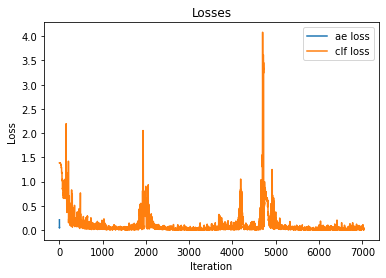

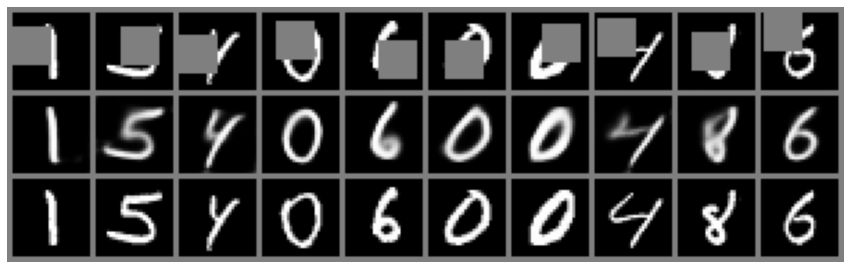

In [23]:
q1_results(q1)

# Question 2. Rotations Prediction

Here we will imlement this [paper](https://arxiv.org/abs/1803.07728). Here, model learns good representations for downstream tasks by proxy task of prediciting rotation of the original image.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

We will work with same rotations as in paper (0, 90, 180, 270). You can use architecture AVB task in hw8. Latent dim 128 and 10 epochs should be enough.

**You will provide the following deliverables**


1. Over the course of training, record the loss per batch.
2. Over the course of training, record the accuracy score for each iteration.




In [5]:
class ConvNet(nn.Module): 
    def __init__(self, n_classes: int): 
        super().__init__()
        self.layer_1 = nn.Sequential( 
            nn.Conv2d(1, 32, 3, 1, 1), # 1 x 28 x 28 -> 32 x 28 x 28
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # -> 64 x 14 x 14
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), # -> 128 x 7 x 7
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), # -> 128 x 4 x 4
            nn.ReLU()
        )
        self.layer_2 = nn.Sequential(
            nn.Linear(4 * 4 * 128, 128), 
            nn.ReLU(),
            nn.Linear(128, 64), 
            nn.ReLU(), 
            nn.Linear(64, n_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor: 
        batch_size = x.shape[0]
        out = self.layer_1(x)
        out = out.view(batch_size, -1)
        out = self.layer_2(out)
        return out


class RotationDataset(data.Dataset): 
    def __init__(self, dataset: data.Dataset): 
        self.examples = (dataset.data / 255) * 2 - 1

    def __getitem__(self, index: int) -> Tuple[np.ndarray, int]:
        k = random.randint(0, 3)
        img = np.rot90(self.examples[index], k=k)[np.newaxis, ...]
        return img.copy(), k

    def __len__(self) -> int: 
        return len(self.examples)

In [6]:
class RotPredModel(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.classifier = ConvNet(4)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")

    def fit(self, 
            train_data: RotationDataset,
            lr: float = 1e-3, 
            batch_size: int = 128, 
            n_epochs: int = 10) -> Tuple[np.ndarray, np.ndarray]: 
        self.train()
        train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        optimizer = opt.Adam(self.parameters(), lr=lr)

        losses, scores = [], []

        for _ in trange(n_epochs, desc="Epoch"):
            correct = total = 0
            for x, labels in tqdm(train_loader, desc="Iteration", leave=False): 
                batch_size = x.shape[0]
                total += batch_size 

                x, labels = x.float().to(device), labels.to(device)
                preds = self.classifier(x)
                loss = self.criterion(preds, labels) / batch_size

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses.append(loss.item())

                correct += (torch.argmax(preds, dim=1) == labels).sum().item()

            scores.append(correct / total)

        return losses, scores

In [11]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    Returns
    - a (# of training iterations, ) numpy array of full of losses
    - a (# of training epochs, ) numpy array of full of accuracy scores
    """
    model = RotPredModel().to(device)
    dataset = RotationDataset(train_data)
    return model.fit(dataset, n_epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

Iteration:   0%|          | 0/469 [00:00<?, ?it/s]

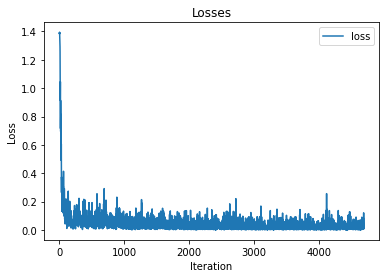

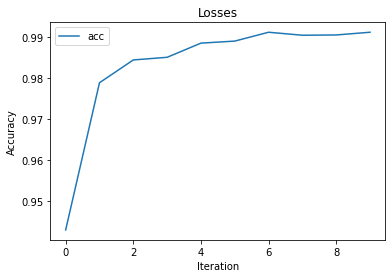

In [12]:
q2_results(q2)